In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from scipy import stats
from tqdm import tqdm
import random

In [2]:
inputFile = "MAESTRO-d6178bdd-identified_variants_merged_protein_regions-main.tsv"
data = pd.read_csv(inputFile,sep='\t',low_memory=False)

In [3]:
data_processed = data[['Peptide'] + [c for c in data.columns if 'intensity_for_peptide_variant' in c]]

In [4]:
data_processed.replace(0.0,np.nan, inplace = True)

/tmp/ipykernel_6118/24937952.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed.replace(0.0,np.nan, inplace = True)


In [5]:
data_processed = data_processed.set_index("Peptide")

In [6]:
data_processed = data_processed.T

In [7]:
data_processed.index = data_processed.index.map(lambda x:'.'.join(x.split('.')[:2]))

In [8]:
def create_label(x):
    if "#Healthy" in x:
        return 1
    elif "#Non-severe-COVID-19" in x:
        return 2
    elif "#Severe-COVID-19" in x:
        return 3
    elif "#Symptomatic-non-COVID-19" in x:
        return 4
    else:
        return 0
data_processed["label"]=data_processed.index.map(lambda x: create_label(x))

In [9]:
data_processed = data_processed[data_processed['label']!=0]

In [10]:
#Split Train and Test data after shuffling 
#data_processed.dropna(axis=1,inplace=True)
data_processed = data_processed.sample(frac=1, random_state=42)

data_processed.dropna(axis=1,inplace=True)

train = data_processed.iloc[:66,:]
test = data_processed.iloc[66:,:]

In [11]:
# #Filter Data based on NaN for each label in training data
# per_label_count = train.groupby('label').count()
# filterCondition = (per_label_count >= 10).all()
# filter_per_label = per_label_count.loc[:, filterCondition]
# filter_column = list(filter_per_label.columns) +['label']
# filter_data =  train[filter_column]

In [12]:
# for column in tqdm(filter_data):
#     if column != "label":
#         filter_data[column] = filter_data.groupby("label")[column].transform(lambda x: x.fillna(x.mean()))

In [13]:
##filter_data.to_csv("filterd_data.tsv", sep="\t")
train.shape

(66, 10635)

In [14]:
#filter_data = train
# corr = train.corr()

In [15]:
#Correlation Matrix
# columns = np.full((corr.shape[0],), True, dtype=bool)
# for i in range(corr.shape[0]):
#     for j in range(i+1, corr.shape[0]):
#         if corr.iloc[i,j] >= 0.9:
#             if columns[j]:
#                 columns[j] = False
# selected_columns = train.columns[columns]
# train = train[selected_columns]

In [16]:
# print(len(selected_columns))
# print(train.shape)

In [17]:
##Ttest 
from itertools import combinations
from scipy import stats
from collections import defaultdict

grouped_df = train.groupby('label')
label_key = list(grouped_df.groups.keys())
peptide_key = list(grouped_df.get_group(label_key[0]).keys())


def ttest_run(c1, c2):
    results = stats.ttest_ind(c1, c2, equal_var=False, alternative='two-sided')
    if results.pvalue < 0.05:
        return 1
    return 0
    

imp = []
for p in tqdm(peptide_key):
    group_peptide = defaultdict(dict)
    for k in label_key: 
        group_peptide[k] = grouped_df.get_group(k)[p]
    
    ttest = [ttest_run(list(group_peptide[i]),list(group_peptide[j])) for i, j in combinations(label_key, 2)]
    if sum(ttest) > 0:
        imp.append(p)

    

100%|██████████| 10635/10635 [00:39<00:00, 267.70it/s]


In [18]:
len(imp)

1595

In [19]:
train = train[imp]

In [20]:
corr = train.corr()

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = train.columns[columns]
train = train[selected_columns]

print(len(selected_columns))
print(train.shape)

945
(66, 945)


In [21]:
test1 = test[train.columns]
# test1 = test1.fillna(0.0)

In [22]:
test1.shape

(24, 945)

In [23]:
## Logistic Regression 

X_train, Y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_test, Y_test = test1.iloc[:,:-1], test1.iloc[:,-1]


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  accuracy_score
from sklearn.metrics import  classification_report

# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


In [25]:
lr = LogisticRegression()
lr.fit(X_train,Y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [26]:
lr_Y = lr.predict(X_test)
lr_acc = accuracy_score(Y_test, lr_Y)
print(lr_acc)
print(classification_report(Y_test, lr_Y))

0.875
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       0.80      1.00      0.89         4
           3       1.00      0.62      0.77         8
           4       0.78      1.00      0.88         7

    accuracy                           0.88        24
   macro avg       0.89      0.91      0.88        24
weighted avg       0.90      0.88      0.87        24



In [27]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, Y_train)
y_pred = classifier.predict(X_test)
rf_acc = accuracy_score(Y_test, y_pred)
rf_acc

0.5416666666666666

In [28]:
Y_test 

_dyn_#Severe-COVID-19.XG39               3
_dyn_#Severe-COVID-19.XG26               3
_dyn_#Symptomatic-non-COVID-19.JBDZ22    4
_dyn_#Severe-COVID-19.XG38               3
_dyn_#Non-severe-COVID-19.XG19           2
_dyn_#Symptomatic-non-COVID-19.JBDZ6     4
_dyn_#Severe-COVID-19.XG40               3
_dyn_#Severe-COVID-19.XG45               3
_dyn_#Symptomatic-non-COVID-19.JBDZ20    4
_dyn_#Non-severe-COVID-19.XG23           2
_dyn_#Non-severe-COVID-19.XG16           2
_dyn_#Healthy.HC10                       1
_dyn_#Severe-COVID-19.XG33               3
_dyn_#Healthy.Patient-group-jkdz         1
_dyn_#Healthy.HC12                       1
_dyn_#Non-severe-COVID-19.XG1            2
_dyn_#Symptomatic-non-COVID-19.JBDZ4     4
_dyn_#Symptomatic-non-COVID-19.JBDZ18    4
_dyn_#Symptomatic-non-COVID-19.JBDZ3     4
_dyn_#Healthy.HC9                        1
_dyn_#Severe-COVID-19.XG42               3
_dyn_#Symptomatic-non-COVID-19.JBDZ15    4
_dyn_#Healthy.HC28                       1
_dyn_#Sever

In [30]:
# import matplotlib.pyplot as plt

# y = train[['-.[304.207](L,43.006)(K,304.207)(C,57.021)DEWSVNSVG(K,304.207).I', 'label']]
# val = y.groupby('label').mean()
# plt.scatter(list(val.index),list(val.values))
# plt.plot()

In [31]:
# val.values

In [30]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [31]:
lr1 = LogisticRegression()

In [32]:
min_features_to_select = 1000  # Minimum number of features to consider
rfecv = RFECV(
    estimator=lr1,
    step=1,
    cv=StratifiedKFold(5),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)

In [33]:
rfecv.fit(X_train, Y_train)
rfecv_Y = rfecv.predict(X_test)
rfecv_acc = accuracy_score(Y_test, rfecv_Y)
rfecv_acc


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

0.875

In [34]:
rfecv_acc

0.875

In [35]:
imp

['D.[215.050]LLFRDDTV(C,57.021)LA(K,304.207).L',
 'K.[304.207]NY(C,57.021)GLPGEYWLGND(K,304.207).I',
 'K.[304.207]DNENVVNEYSSELE(K,304.207).H',
 'K.{52.914}[304.207]NLNE(K,304.207)DYELL(C,57.021)LDGTR.K',
 'K.{16.002}[304.207]NLNE(K,304.207)DYELL(C,57.021)LDGTR.K',
 'K.{95.076}[304.207]NLNE(K,304.207)DYEL.L',
 'R.[304.207](K,304.207)(P,37.954)VEEYAN(C,57.021)HLAR.A',
 'K.[304.207]L(C,57.021)MGSGLNL(C,109.935)EPNN(K,304.207).E',
 'K.{12.176}[304.207]L(C,57.021)MGSGLNL(C,57.021)EPNN(K,304.207).E',
 'R.{43.962}[304.207]FDEFFSEG(C,57.021)APGS(K,304.207).K',
 'R.{52.928}[304.207]FDEFFSEG(C,57.021)APGS(K,304.207)(K,304.207).D',
 'R.[304.207]FDEFFSEG(C,57.021)APG(S,228.116).K',
 'R.[304.207]FDEFFSEG(C,57.021)APGS(K,198.099)(K,304.207).D',
 'K.{52.918}[304.207]L(C,57.021)MGSGLNL(C,57.021)EPNN(K,304.207).E',
 'K.{17.026}[304.207]L(C,57.021)MGSGLNL(C,57.021)EPNN(K,304.207).E',
 'R.[304.207]FDEFF(S,52.918)EG(C,57.021)APGS(K,304.207).K',
 'R.[304.207]FDEFF(S,100.023)EG(C,57.021)APGS(K,304.207).K',

In [36]:
print(rfecv.n_features_)

767


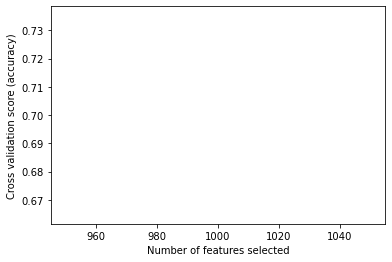

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()